Data Increase + Batch normalization + Dropout + Stochastic Depth

# Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
!pip install einops
from einops import rearrange

import torch.optim
import torch.utils.data
#!pip install torchvision==0.11.1
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.4 MB/s eta 0:00:00


In [2]:
!pip install timm
from timm.models.layers import DropPath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

In [4]:
PATH="datasets"

In [5]:
cuda="cuda"
def load_data(batch_size=128, img_size=128):
    # Donwload the dataset
    transform = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    dataset = datasets.Caltech101("data",download=True,transform=transform)

    # Train test split
    train_dataset, test_dataset = torch.utils.data.random_split(dataset,lengths=[0.7,0.3],generator=torch.Generator().manual_seed(42))

    # Dataloader
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=False)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=False)

    return trainloader, testloader

# Model

## Ours

In [ ]:
def imgs_to_SoP(imgs):
    shape = imgs.shape
    height = shape[-2]
    width = shape[-1]
    batch = shape[0]
    
    ind_w = torch.arange(width)/(width-1)-0.5
    ind_h = torch.arange(height)/(height-1)-0.5
    ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)
    
    batch_ind = ind.repeat(batch,1,1,1)
    #flat_imgs = imgs.flatten(start_dim=len(shape)-2) #laisser en b c h w ?
    
    SoP = torch.cat((imgs,batch_ind),dim=1)
    
    return SoP

In [ ]:
class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)

In [ ]:
class PointReducer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=2, stride=2, norm_layer=None):
        super().__init__()
        self.conv2d = nn.Conv2d(in_chan, out_chan, kernel_size, stride)
        self.norm = norm_layer(out_chan) if norm_layer else nn.Identity()

    def forward(self,input):
        out = self.conv2d(input)
        out = self.norm(out)
        return out

In [ ]:
def pairwise_cosine_sim(x1, x2):
    x1_norm = F.normalize(x1, dim=-1) 
    x2_norm = F.normalize(x2, dim=-1)
    
    sim = x1_norm @ x2_norm.transpose(-2,-1) #to compute for each pair in the batch
    
    return sim

In [ ]:
class Cluster(nn.Module):
    def __init__(self,in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2):
        super().__init__()
        
        self.heads = heads
        self.head_dim = head_dim
        self.fold_w = fold_w
        self.fold_h = fold_h
        
        self.fc1 = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
            #heads*head_dim -> we place the heads in the batch later
        self.fcv = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
        self.fc2 = nn.Conv2d(heads*head_dim,out_channels,kernel_size = 1)
        self.center_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        
        self.alpha = nn.Parameter(torch.ones(1)) #initialisation bizarre
        self.beta = nn.Parameter(torch.zeros(1)) #initialisation bizarre
        
    def forward(self,x):
        """
        x : [b,c,h,w]
        """
        _,_,h,w = x.shape 
        
        val = self.fcv(x)
        x = self.fc1(x)

        # separating heads
        x = rearrange(x, "b (e c) h w -> (b e) c h w", e=self.heads)
        val = rearrange(val, "b (e c) h w -> (b e) c h w", e=self.heads) 
        
        #splitting patches 
        if self.fold_w>1 and self.fold_h>1:
            assert w%self.fold_w==0 and h%self.fold_h==0
            x = rearrange(x, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
            val = rearrange(val, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
        _,_,h,w = x.shape
        #computing cluster centers
        cluster_centers = self.center_proposal(x) #(b,c,Cw,Ch)
        center_values = rearrange(self.center_proposal(val) , 'b c h w -> b (h w) c') #(b,Cw*Ch,c) = (b,m,c)
        
        b,c,_,_ = cluster_centers.shape

        #computing similarity
        sim = torch.sigmoid(self.beta + self.alpha*pairwise_cosine_sim(cluster_centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #(b,Cw*Ch,h*w) = (b,m,n)
        sim_max, sim_argmax = sim.max(dim = 1, keepdim = True)
        
        #assigning a cluster to each point
        mask = torch.zeros_like(sim) #(b,m,n)
        mask.scatter_(1, sim_argmax, 1.)
        sim= sim*mask
        
        #computing aggregated feature
        val = rearrange(val, 'b c h w -> b (h w) c')
        out = ((val.unsqueeze(dim=1)*sim.unsqueeze(dim=-1)).sum(dim=2) + center_values)/(mask.sum(dim=-1,keepdim=True)+ 1)
        
        out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1)
        out = rearrange(out, "b (h w) c -> b c h w", h=h)
        
        #recovering splitted patches
        if self.fold_w>1 and self.fold_h>1:
            out = rearrange(out, "(b f1 f2) c h w -> b c (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)
        
        #regrouping heads
        out = rearrange(out, "(b e) c h w -> b (e c) h w", e=self.heads)
        out = self.fc2(out)

        return out

In [ ]:
class MLP(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,act,dropout=0):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels,hidden_channels,kernel_size=1),act()]
        if dropout:
            layers.append(nn.Dropout(dropout))
        layers += [nn.Conv2d(hidden_channels,out_channels,kernel_size=1),act()]
        
        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        out = self.net(x)
        return out

In [ ]:
#add droppath ???
class ClusterBlock(nn.Module):
    
    def __init__(self,in_channels,act=nn.GELU,mlp_ratio=4,dropout=0,droppath=0,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2,heads=4,head_dim=16,norm_layer=GroupNorm):
        super().__init__()
        
        #(in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2))
        self.cluster = Cluster(in_channels,in_channels,heads,head_dim,proposal_w,proposal_h,fold_w,fold_h)
        hidden_dim = int(mlp_ratio*in_channels)
        self.mlp = MLP(in_channels,hidden_dim,in_channels,act,dropout=dropout)
        self.norm1 = norm_layer(in_channels)
        self.norm2 = norm_layer(in_channels)
        
        self.droppath = DropPath(droppath)
        
    def forward(self,x):
        x = x + self.droppath(self.cluster(self.norm1(x))) #skip conn
        out = x + self.droppath(self.mlp(self.norm2(x))) #skip conn
        return out

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,N=1,heads=4,head_dim=16,mlp_ratio=4,fold=2,norm_layer=GroupNorm,dropout=0,droppath=0):
        super().__init__()
        self.point_red = PointReducer(in_channels,out_channels)
        layers = []
        for i in range(N):
            layers.append(ClusterBlock(out_channels,heads=heads,head_dim=head_dim,mlp_ratio=mlp_ratio,norm_layer=norm_layer,dropout=dropout,droppath=droppath,fold_h=fold,fold_w=fold))
        self.cluster_b = nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.point_red(x)
        x = self.cluster_b(x)
        return x

In [ ]:
class Model(nn.Module):
    def __init__(self,embedding_sizes,num_classes,n_blocks=[1,1,1,1],head_counts=[4,4,4,4],head_dims=[16,16,16,16],mlp_ratios=[4,4,4,4],norm_layer=GroupNorm,dropout=0,droppath=0):
        super().__init__()
        layers = []
        in_channels = 5
        
        #for out_channels in embedding_sizes:
            #layers.append(BasicBlock(in_channels,out_channels,norm_layer=norm_layer,dropout=dropout))
            #in_channels = out_channels


        for stage,out_channels in enumerate(embedding_sizes):
            N = n_blocks[stage]
            heads = head_counts[stage]
            head_dim = head_dims[stage]
            mlp_ratio= mlp_ratios[stage]
            fold = folds[stage]
            
            layers.append(BasicBlock(in_channels,out_channels,N=N,heads=heads,head_dim=head_dim,mlp_ratio=mlp_ratio,fold=fold,norm_layer=norm_layer,dropout=dropout,droppath=droppath))
            in_channels = out_channels


        
        self.feature_extractor = nn.Sequential(*layers)
        self.clf = nn.Linear(embedding_sizes[-1],num_classes)
        self.old_shape = None


    def imgs_to_SoP(self,imgs):
        """
        Transform a batch of images to a bacth of sets of points

        imgs : torch.Tensor([batch,chan,height,width])
        return : torch.Tensor([batch,chan+2,height*width])
        """
        shape = imgs.shape
        if self.old_shape != shape:
            self.old_shape = shape
            height = shape[-2]
            width = shape[-1]
            batch = shape[0]
            
            ind_w = torch.arange(width)/(width-1)-0.5
            ind_h = torch.arange(height)/(height-1)-0.5
            ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)

            self.batch_ind = ind.repeat(batch,1,1,1)
        
        device = imgs.device
        #flat_imgs = imgs.flatten(start_dim=len(shape)-2)
        SoP = torch.cat((imgs,self.batch_ind.to(device)),dim=1) #might need to clone
        
        return SoP

    def forward(self,input):
        SoP = self.imgs_to_SoP(input)
        features = self.feature_extractor(SoP)
        features = torch.mean(features, dim = (2,3))
        yhat = self.clf(features)
        return yhat

## Pretrained

In [6]:
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model
from timm.models.layers.helpers import to_2tuple

import copy

!pip install mmsegmentation
try:
    from mmseg.models.builder import BACKBONES as seg_BACKBONES
    from mmseg.utils import get_root_logger
    from mmcv.runner import _load_checkpoint
    has_mmseg = True
except ImportError:
    print("If for semantic segmentation, please install mmsegmentation first")
    has_mmseg = False

try:
    from mmdet.models.builder import BACKBONES as det_BACKBONES
    from mmdet.utils import get_root_logger
    from mmcv.runner import _load_checkpoint
    has_mmdet = True
except ImportError:
    print("If for detection, please install mmdetection first")
    has_mmdet = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.7/831.7 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.8/648.8 KB 52.1 MB/s eta 0:00:00
If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first


In [7]:
def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224),
        'crop_pct': .95, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'model_small': _cfg(crop_pct=0.9),
    'model_medium': _cfg(crop_pct=0.95),
}


class PointReducer(nn.Module):
    """
    Point Reducer is implemented by a layer of conv since it is mathmatically equal.
    Input: tensor in shape [B, C, H, W]
    Output: tensor in shape [B, C, H/stride, W/stride]
    """
    def __init__(self, patch_size=16, stride=16, padding=0,
                 in_chans=3, embed_dim=768, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        stride = to_2tuple(stride)
        padding = to_2tuple(padding)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size,
                              stride=stride, padding=padding)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return x

class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)


def pairwise_cos_sim(x1: torch.Tensor, x2:torch.Tensor):
    """
    return pair-wise similarity matrix between two tensors
    :param x1: [B,...,M,D]
    :param x2: [B,...,N,D]
    :return: similarity matrix [B,...,M,N]
    """
    x1 = F.normalize(x1,dim=-1)
    x2 = F.normalize(x2,dim=-1)

    sim = torch.matmul(x1, x2.transpose(-2, -1))
    return sim

class Cluster(nn.Module):
    def __init__(self, dim, out_dim, proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False):
        """

        :param dim:  channel nubmer
        :param out_dim: channel nubmer
        :param proposal_w: the sqrt(proposals) value, we can also set a different value
        :param proposal_h: the sqrt(proposals) value, we can also set a different value
        :param fold_w: the sqrt(number of regions) value, we can also set a different value
        :param fold_h: the sqrt(number of regions) value, we can also set a different value
        :param heads:  heads number in context cluster
        :param head_dim: dimension of each head in context cluster
        :param return_center: if just return centers instead of dispatching back (deprecated).
        """
        super().__init__()
        self.heads = heads
        self.head_dim=head_dim
        self.fc1 = nn.Conv2d(dim, heads*head_dim, kernel_size=1)
        self.fc2 = nn.Conv2d(heads*head_dim, out_dim, kernel_size=1)
        self.fc_v = nn.Conv2d(dim, heads*head_dim, kernel_size=1)
        self.sim_alpha = nn.Parameter(torch.ones(1))
        self.sim_beta = nn.Parameter(torch.zeros(1))
        self.centers_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        self.fold_w=fold_w
        self.fold_h = fold_h
        self.return_center = return_center

    def forward(self, x): #[b,c,w,h]
        value = self.fc_v(x)
        x = self.fc1(x)
        x = rearrange(x, "b (e c) w h -> (b e) c w h", e=self.heads)
        value = rearrange(value, "b (e c) w h -> (b e) c w h", e=self.heads)
        if self.fold_w>1 and self.fold_h>1:
            # split the big feature maps to small loca regions to reduce computations of matrix multiplications.
            b0,c0,w0,h0 = x.shape
            assert w0%self.fold_w==0 and h0%self.fold_h==0, \
                f"Ensure the feature map size ({w0}*{h0}) can be divided by fold {self.fold_w}*{self.fold_h}"
            x = rearrange(x, "b c (f1 w) (f2 h) -> (b f1 f2) c w h", f1=self.fold_w, f2=self.fold_h) #[bs*blocks,c,ks[0],ks[1]]
            value = rearrange(value, "b c (f1 w) (f2 h) -> (b f1 f2) c w h", f1=self.fold_w, f2=self.fold_h)
        b,c,w,h = x.shape
        centers = self.centers_proposal(x)  # [b,c,C_W,C_H], we set M = C_W*C_H and N = w*h
        value_centers = rearrange(self.centers_proposal(value) , 'b c w h -> b (w h) c') # [b,C_W,C_H,c]
        b,c,ww,hh = centers.shape
        sim = torch.sigmoid(self.sim_beta + self.sim_alpha * pairwise_cos_sim(centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #[B,M,N]
        # sololy assign each point to one center
        sim_max, sim_max_idx = sim.max(dim=1,keepdim=True)
        mask = torch.zeros_like(sim)  # binary #[B,M,N]
        mask.scatter_(1, sim_max_idx, 1.)
        sim= sim*mask
        value2 = rearrange(value, 'b c w h -> b (w h) c')  # [B,N,D]
        # out shape [B,M,D]
        out = ( ( value2.unsqueeze(dim=1)*sim.unsqueeze(dim=-1) ).sum(dim=2) + value_centers)/ (mask.sum(dim=-1,keepdim=True)+ 1.0) # [B,M,D]

        if self.return_center:
            out = rearrange(out, "b (w h) c -> b c w h", w=ww)
        # return to each point in a cluster
        else:
            out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1) # [B,N,D]
            out = rearrange(out, "b (w h) c -> b c w h", w=w)

        if self.fold_w>1 and self.fold_h>1: # recover the splited regions back to big feature maps
            out = rearrange(out, "(b f1 f2) c w h -> b c (f1 w) (f2 h)", f1=self.fold_w, f2=self.fold_h)
        out = rearrange(out, "(b e) c w h -> b (e c) w h", e=self.heads)
        out = self.fc2(out)
        return out

class Mlp(nn.Module):
    """
    Implementation of MLP with 1*1 convolutions.
    Input: tensor with shape [B, C, H, W]
    """
    def __init__(self, in_features, hidden_features=None,
                 out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class ClusterBlock(nn.Module):
    """
    Implementation of one block.
    --dim: embedding dim
    --mlp_ratio: mlp expansion ratio
    --act_layer: activation
    --norm_layer: normalization
    --drop: dropout rate
    --drop path: Stochastic Depth,
        refer to https://arxiv.org/abs/1603.09382
    --use_layer_scale, --layer_scale_init_value: LayerScale,
        refer to https://arxiv.org/abs/2103.17239
    """
    def __init__(self, dim, mlp_ratio=4.,
                 act_layer=nn.GELU, norm_layer=GroupNorm,
                 drop=0., drop_path=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5,
                 # for context-cluster
                 proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False):

        super().__init__()

        self.norm1 = norm_layer(dim)
        # dim, out_dim, proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False
        self.token_mixer = Cluster(dim=dim, out_dim=dim, proposal_w=proposal_w,proposal_h=proposal_h,
                                   fold_w=fold_w, fold_h=fold_h, heads=heads, head_dim=head_dim, return_center=False)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

        # The following two techniques are useful to train deep ContextClusters.
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.use_layer_scale = use_layer_scale
        if use_layer_scale:
            self.layer_scale_1 = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            self.layer_scale_2 = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        if self.use_layer_scale:
            x = x + self.drop_path(
                self.layer_scale_1.unsqueeze(-1).unsqueeze(-1)
                * self.token_mixer(self.norm1(x)))
            x = x + self.drop_path(
                self.layer_scale_2.unsqueeze(-1).unsqueeze(-1)
                * self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.token_mixer(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

def basic_blocks(dim, index, layers,
                 mlp_ratio=4.,
                 act_layer=nn.GELU, norm_layer=GroupNorm,
                 drop_rate=.0, drop_path_rate=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5,
                 # for context-cluster
                 proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False):
    blocks = []
    for block_idx in range(layers[index]):
        block_dpr = drop_path_rate * (
            block_idx + sum(layers[:index])) / (sum(layers) - 1)
        blocks.append(ClusterBlock(
            dim, mlp_ratio=mlp_ratio,
            act_layer=act_layer, norm_layer=norm_layer,
            drop=drop_rate, drop_path=block_dpr,
            use_layer_scale=use_layer_scale,
            layer_scale_init_value=layer_scale_init_value,
            proposal_w=proposal_w, proposal_h=proposal_h, fold_w=fold_w, fold_h=fold_h,
            heads=heads, head_dim=head_dim, return_center=False
            ))
    blocks = nn.Sequential(*blocks)

    return blocks

class ContextCluster(nn.Module):
    """
    ContextCluster, the main class of our model
    --layers: [x,x,x,x], number of blocks for the 4 stages
    --embed_dims, --mlp_ratios, the embedding dims, mlp ratios
    --downsamples: flags to apply downsampling or not
    --norm_layer, --act_layer: define the types of normalization and activation
    --num_classes: number of classes for the image classification
    --in_patch_size, --in_stride, --in_pad: specify the patch embedding
        for the input image
    --down_patch_size --down_stride --down_pad:
        specify the downsample (patch embed.)
    --fork_feat: whether output features of the 4 stages, for dense prediction
    --init_cfg, --pretrained:
        for mmdetection and mmsegmentation to load pretrained weights
    """
    def __init__(self, layers, embed_dims=None,
                 mlp_ratios=None, downsamples=None,
                 norm_layer=nn.BatchNorm2d, act_layer=nn.GELU,
                 num_classes=1000,
                 in_patch_size=4, in_stride=4, in_pad=0,
                 down_patch_size=2, down_stride=2, down_pad=0,
                 drop_rate=0., drop_path_rate=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5,
                 fork_feat=False,
                 init_cfg=None,
                 pretrained=None,
                 # the parameters for context-cluster
                 img_w=224,img_h=224,
                 proposal_w=[2,2,2,2], proposal_h=[2,2,2,2], fold_w=[8,4,2,1], fold_h=[8,4,2,1],
                 heads=[2,4,6,8], head_dim=[16,16,32,32],
                 **kwargs):

        super().__init__()
        if not fork_feat:
            self.num_classes = num_classes
        self.fork_feat = fork_feat

        # register positional information buffer.
        range_w = torch.arange(0, img_w, step=1)/(img_w-1.0)
        range_h = torch.arange(0, img_h, step=1)/(img_h-1.0)
        fea_pos = torch.stack(torch.meshgrid(range_w, range_h, indexing = 'ij'), dim = -1).float()
        fea_pos = fea_pos-0.5
        self.register_buffer('fea_pos', fea_pos)

        self.patch_embed = PointReducer(
            patch_size=in_patch_size, stride=in_stride, padding=in_pad,
            in_chans=5, embed_dim=embed_dims[0])

        # set the main block in network
        network = []
        for i in range(len(layers)):
            stage = basic_blocks(embed_dims[i], i, layers,
                                 mlp_ratio=mlp_ratios[i],
                                 act_layer=act_layer, norm_layer=norm_layer,
                                 drop_rate=drop_rate,
                                 drop_path_rate=drop_path_rate,
                                 use_layer_scale=use_layer_scale,
                                 layer_scale_init_value=layer_scale_init_value,
                                 proposal_w=proposal_w[i],proposal_h=proposal_h[i],
                                 fold_w=fold_w[i], fold_h=fold_h[i], heads=heads[i], head_dim=head_dim[i],
                                 return_center=False
                                 )
            network.append(stage)
            if i >= len(layers) - 1:
                break
            if downsamples[i] or embed_dims[i] != embed_dims[i+1]:
                # downsampling between two stages
                network.append(
                    PointReducer(
                        patch_size=down_patch_size, stride=down_stride,
                        padding=down_pad,
                        in_chans=embed_dims[i], embed_dim=embed_dims[i+1]
                        )
                    )

        self.network = nn.ModuleList(network)

        if self.fork_feat:
            # add a norm layer for each output
            self.out_indices = [0, 2, 4, 6]
            for i_emb, i_layer in enumerate(self.out_indices):
                if i_emb == 0 and os.environ.get('FORK_LAST3', None):
                    # TODO: more elegant way
                    """For RetinaNet, `start_level=1`. The first norm layer will not used.
                    cmd: `FORK_LAST3=1 python -m torch.distributed.launch ...`
                    """
                    layer = nn.Identity()
                else:
                    layer = norm_layer(embed_dims[i_emb])
                layer_name = f'norm{i_layer}'
                self.add_module(layer_name, layer)
        else:
            # Classifier head
            self.norm = norm_layer(embed_dims[-1])
            self.head = nn.Linear(
                embed_dims[-1], num_classes) if num_classes > 0 \
                else nn.Identity()

        self.apply(self.cls_init_weights)

        self.init_cfg = copy.deepcopy(init_cfg)
        # load pre-trained model
        if self.fork_feat and (
                self.init_cfg is not None or pretrained is not None):
            self.init_weights()

    # init for classification
    def cls_init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # init for mmdetection or mmsegmentation by loading
    # imagenet pre-trained weights
    def init_weights(self, pretrained=None):
        logger = get_root_logger()
        if self.init_cfg is None and pretrained is None:
            logger.warn(f'No pre-trained weights for '
                        f'{self.__class__.__name__}, '
                        f'training start from scratch')
            pass
        else:
            assert 'checkpoint' in self.init_cfg, f'Only support ' \
                                                  f'specify `Pretrained` in ' \
                                                  f'`init_cfg` in ' \
                                                  f'{self.__class__.__name__} '
            if self.init_cfg is not None:
                ckpt_path = self.init_cfg['checkpoint']
            elif pretrained is not None:
                print("getting pretrained weights")
                ckpt_path = pretrained

            ckpt = _load_checkpoint(
                ckpt_path, logger=logger, map_location='cpu')
            if 'state_dict' in ckpt:
                _state_dict = ckpt['state_dict']
            elif 'model' in ckpt:
                _state_dict = ckpt['model']
            else:
                _state_dict = ckpt

            state_dict = _state_dict
            missing_keys, unexpected_keys = \
                self.load_state_dict(state_dict, False)

            # show for debug
            # print('missing_keys: ', missing_keys)
            # print('unexpected_keys: ', unexpected_keys)

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes):
        self.num_classes = num_classes
        self.head = nn.Linear(
            self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_embeddings(self, x):
        # print(self.fea_pos.shape)
        pos = self.fea_pos.permute(2,0,1).unsqueeze(dim=0).expand(x.shape[0],-1,-1,-1)
        x = self.patch_embed(torch.cat([x,pos], dim=1))
        return x

    def forward_tokens(self, x):
        outs = []
        for idx, block in enumerate(self.network):
            x = block(x)
            if self.fork_feat and idx in self.out_indices:
                norm_layer = getattr(self, f'norm{idx}')
                x_out = norm_layer(x)
                outs.append(x_out)
        if self.fork_feat:
            # output the features of four stages for dense prediction
            return outs
        # output only the features of last layer for image classification
        return x

    def forward(self, x):
        # input embedding
        # print(x.shape)
        x = self.forward_embeddings(x)
        # print(x.shape)
        # through backbone
        x = self.forward_tokens(x)
        if self.fork_feat:
            # otuput features of four stages for dense prediction
            return x
        x = self.norm(x)
        cls_out = self.head(x.mean([-2, -1]))
        # for image classification
        return cls_out

def coc_tiny(pretrained=False, **kwargs):
    layers = [3, 4, 5, 2]
    norm_layer=GroupNorm
    embed_dims = [32, 64, 196, 320]
    mlp_ratios = [8, 8, 4, 4]
    downsamples = [True, True, True, True]
    proposal_w=[2,2,2,2]
    proposal_h=[2,2,2,2]
    fold_w=[8,4,2,1]
    fold_h=[8,4,2,1]
    heads=[4,4,8,8]
    head_dim=[24,24,24,24]
    down_patch_size=3
    down_pad = 1
    model = ContextCluster(
        layers, embed_dims=embed_dims, norm_layer=norm_layer,
        mlp_ratios=mlp_ratios, downsamples=downsamples,
        down_patch_size = down_patch_size, down_pad=down_pad,
        pretrained=pretrained,
        proposal_w=proposal_w, proposal_h=proposal_h, fold_w=fold_w, fold_h=fold_h,
        heads=heads, head_dim=head_dim,
        **kwargs)
    model.default_cfg = default_cfgs['model_small']
    return model


In [10]:
class CaltechModel(nn.Module):
    def __init__(self, pretrained_model, embedding_sizes, num_classes):
        super(CaltechModel, self).__init__()
        # Features extracted with the pretrained model
        self.pretrained_model = pretrained_model
        for p in self.pretrained_model.parameters():
            p.requires_grad = False # freezing weights
        # Classifier to be trained
        self.clf = self.clf = nn.Linear(embedding_sizes[-1], num_classes)

    def forward(self, x):
        x = self.pretrained_model.forward_embeddings(x)
        x = self.pretrained_model.forward_tokens(x)
        # x = x.view(x.size(0), -1)
        x = torch.mean(x, dim = (2,3))
        x = self.clf(x)
        return x

# Tests

In [12]:
savepath = "drive/MyDrive/AMAL/"

In [32]:
def main(model, n_epochs, device, batch_size=64, img_size=128):
    cuda = True

    train_loader, test_loader = load_data(batch_size,img_size)    

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optim = torch.optim.AdamW(model.parameters())
    
    List_Train_Loss = []
    List_Train_acc = []
    List_Test_acc = []
    max_acc = 0.0
    
    for epoch in range(n_epochs):
        model.train()
        losses = []
        train_acc, train_total = 0.0, 0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            optim.zero_grad()
            
            yhat = model(X)

            l = criterion(yhat,y)
            l.backward()
            
            optim.step()

            ypred = torch.argmax(yhat,dim = 1)
            train_acc += torch.sum(y==ypred).detach().cpu()
            train_total += len(y)
            losses.append(l.detach().cpu())
        List_Train_acc.append(train_acc.item()/train_total)

        if epoch % 10 == 0:
            test_acc, test_total = 0.0, 0
            model.eval()
            for X,y in test_loader:
                X,y = X.to(device), y.to(device)
                yhat = model(X)

                ypred = torch.argmax(yhat,dim = 1)
                test_acc += torch.sum(y==ypred)
                test_total += len(y)
                #l = Loss(yhat,y)
            List_Test_acc.append(test_acc.item()/test_total)
            if test_acc.item() > max_acc:
                max_acc = test_acc.item()
                torch.save(model.state_dict(), savepath+'models/caltechpretrained-tiny.cpkt')
            
        List_Train_Loss.append(torch.mean(torch.stack(losses)).detach().cpu())
        if epoch % 10 == 0:
            print(f"epoch n°{epoch} : loss = {List_Train_Loss[-1]}, acc = {test_acc.item()/test_total}")
        else:
            print(f"epoch n°{epoch} : loss = {List_Train_Loss[-1]}")
    
    torch.save(List_Train_acc, savepath+"log/Train_acc.pt")
    torch.save(List_Test_acc, savepath+"log/Test_acc.pt")
    torch.save(List_Train_Loss, savepath+"log/Train_loss.pt")

    plt.figure()
    plt.plot(range(n_epochs),List_Train_Loss)
    plt.title("Evolution of the training loss")
    plt.savefig(savepath+"log/Train_loss.svg")
    plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(range(int(np.ceil(n_epochs/10))),List_Test_acc)
    plt.title("Evolution of the test performance")
    plt.savefig(savepath+"log/Test_acc.svg")
    plt.show()
    plt.close()

    plt.figure()
    plt.plot(range(int(np.ceil(n_epochs))),List_Train_acc)
    plt.title("Evolution of the train performance")
    plt.savefig(savepath+"log/Train_acc.svg")
    plt.show()
    plt.close()
    

In [18]:
def evaluate(model,device,batch_size=64,img_size=128):
    cuda = True
    model.eval()

    _, test_loader = load_data(batch_size,img_size)    

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optim = torch.optim.AdamW(model.parameters())

    mean_acc = 0.0
    total = 0
    
    for X,y in test_loader:
        X,y = X.to(device), y.to(device)
        yhat = model(X)

        y_pred = torch.argmax(yhat,dim = 1)
        mean_acc += torch.sum(y==y_pred)
        total += len(y)
    
    model.train()
    return mean_acc/total

# caltech

## Experiment 0 : using pretrained model
Using the Coc-tiny pretrained paramaters for the features extractor (trained with ImageNet), and training the final linear classifier on the Caltech101 dataset

In [27]:
device = 'cuda'
pretrained_model = coc_tiny()
pretrained_model.load_state_dict(torch.load(savepath+'models/model_best.pth.tar')["state_dict"])
# summary(pretrained_model,(3,224,224))
embedding_sizes = [32, 64, 196, 320]
num_classes = 101
model = CaltechModel(pretrained_model,embedding_sizes,num_classes).to(device)
# summary(model,(3,224,224))

Before training

In [19]:
start = time.time()
mean_acc = evaluate(model, device, batch_size=64, img_size=224)
stop = time.time()
print(stop-start)
print(mean_acc)

Files already downloaded and verified
14.114408493041992
tensor(0.0619, device='cuda:0')


Training

Files already downloaded and verified
epoch n°0 : loss = 3.2330193519592285, acc = 0.7218593930080676
epoch n°1 : loss = 1.8113865852355957
epoch n°2 : loss = 1.3847254514694214
epoch n°3 : loss = 1.223048448562622
epoch n°4 : loss = 1.1413776874542236
epoch n°5 : loss = 1.0929206609725952
epoch n°6 : loss = 1.0581989288330078
epoch n°7 : loss = 1.0325307846069336
epoch n°8 : loss = 1.0120023488998413
epoch n°9 : loss = 0.9956583380699158
epoch n°10 : loss = 0.9812631607055664, acc = 0.917402996542451
epoch n°11 : loss = 0.9690209031105042
epoch n°12 : loss = 0.9583783745765686
epoch n°13 : loss = 0.9493371248245239
epoch n°14 : loss = 0.9414171576499939
epoch n°15 : loss = 0.9345470070838928
epoch n°16 : loss = 0.9284701943397522
epoch n°17 : loss = 0.9223920106887817
epoch n°18 : loss = 0.9169765114784241
epoch n°19 : loss = 0.9126830101013184
epoch n°20 : loss = 0.9084352254867554, acc = 0.9189396849788706


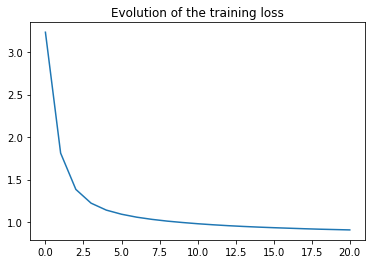

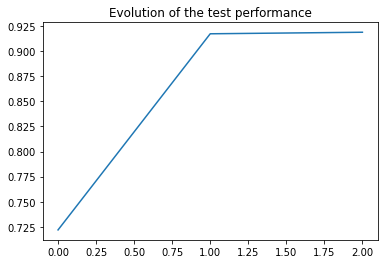

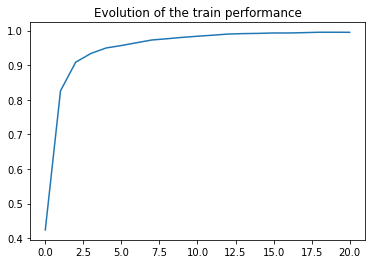

692.350063085556


In [28]:
start = time.time()
main(model, 21, device, batch_size=64, img_size=224)
stop = time.time()
print(stop-start)

### Experiment 1 : training from scratch super tiny model (~50%)

In [ ]:
n_blocks = [3,4,5,2]
embedding_sizes = [32,64,128,256]
head_counts = [4,4,8,8]
head_dims = [16,16,16,16]
mlp_ratios = [8,8,4,4]
folds = [8,4,2,1]
num_classes = 101
device = 'cuda'
model = Model(embedding_sizes,num_classes,n_blocks=n_blocks,head_counts=head_counts,head_dims=head_dims,mlp_ratios=mlp_ratios,dropout=0.5,droppath=0.2).to(device)
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             672
          Identity-2         [-1, 32, 128, 128]               0
      PointReducer-3         [-1, 32, 128, 128]               0
         GroupNorm-4         [-1, 32, 128, 128]              64
            Conv2d-5         [-1, 64, 128, 128]           2,112
            Conv2d-6         [-1, 64, 128, 128]           2,112
 AdaptiveAvgPool2d-7             [-1, 16, 2, 2]               0
 AdaptiveAvgPool2d-8             [-1, 16, 2, 2]               0
            Conv2d-9         [-1, 32, 128, 128]           2,080
          Cluster-10         [-1, 32, 128, 128]               0
         DropPath-11         [-1, 32, 128, 128]               0
        GroupNorm-12         [-1, 32, 128, 128]              64
           Conv2d-13        [-1, 256, 128, 128]           8,448
             GELU-14        [-1, 256, 1

In [ ]:
start = time.time()
main(model,301,device)
stop = time.time()
print(stop-start)
print((stop-start)/300)

Files already downloaded and verified
epoch n°0 : loss = 4.1673078536987305, acc = 0.2197464464079908
epoch n°1 : loss = 3.855879306793213
epoch n°2 : loss = 3.708604574203491
epoch n°3 : loss = 3.548336982727051
epoch n°4 : loss = 3.409528970718384
epoch n°5 : loss = 3.275373697280884
epoch n°6 : loss = 3.1468095779418945
epoch n°7 : loss = 3.043933153152466
epoch n°8 : loss = 2.942150592803955
epoch n°9 : loss = 2.8299355506896973
epoch n°10 : loss = 2.747419834136963, acc = 0.42873607376104494
epoch n°11 : loss = 2.6378841400146484
epoch n°12 : loss = 2.5423693656921387
epoch n°13 : loss = 2.4523234367370605
epoch n°14 : loss = 2.356858015060425
epoch n°15 : loss = 2.27337646484375
epoch n°16 : loss = 2.177194356918335
epoch n°17 : loss = 2.0975682735443115
epoch n°18 : loss = 1.9897124767303467
epoch n°19 : loss = 1.9340237379074097
epoch n°20 : loss = 1.819534182548523, acc = 0.47099500576258163
epoch n°21 : loss = 1.7391120195388794
epoch n°22 : loss = 1.6732149124145508
epoch n°

### Experiment 2 : training from scratch tiny model (~50%)

In [ ]:
# Experiment 2
n_blocks = [3,4,5,2]
embedding_sizes = [32,64,196,320]
head_counts = [4,4,8,8]
head_dims = [16,16,16,16]
mlp_ratios = [8,8,4,4]
folds = [8,4,2,1]
num_classes = 101
device = 'cuda'
model = Model(embedding_sizes,num_classes,n_blocks=n_blocks,head_counts=head_counts,head_dims=head_dims,mlp_ratios=mlp_ratios,dropout=0.5,droppath=0.2).to(device)
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             672
          Identity-2           [-1, 32, 64, 64]               0
      PointReducer-3           [-1, 32, 64, 64]               0
         GroupNorm-4           [-1, 32, 64, 64]              64
            Conv2d-5           [-1, 64, 64, 64]           2,112
            Conv2d-6           [-1, 64, 64, 64]           2,112
 AdaptiveAvgPool2d-7             [-1, 16, 2, 2]               0
 AdaptiveAvgPool2d-8             [-1, 16, 2, 2]               0
            Conv2d-9           [-1, 32, 64, 64]           2,080
          Cluster-10           [-1, 32, 64, 64]               0
         DropPath-11           [-1, 32, 64, 64]               0
        GroupNorm-12           [-1, 32, 64, 64]              64
           Conv2d-13          [-1, 256, 64, 64]           8,448
             GELU-14          [-1, 256,

0it [00:00, ?it/s]

Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


0it [00:00, ?it/s]

Extracting data/caltech101/Annotations.tar to data/caltech101
epoch n°0 : loss = 4.224709510803223, acc = 0.17633499807913947
epoch n°1 : loss = 3.916149854660034
epoch n°2 : loss = 3.742185592651367
epoch n°3 : loss = 3.5627551078796387
epoch n°4 : loss = 3.4082279205322266
epoch n°5 : loss = 3.258460760116577
epoch n°6 : loss = 3.1414451599121094
epoch n°7 : loss = 3.031996250152588
epoch n°8 : loss = 2.917459487915039
epoch n°9 : loss = 2.8024487495422363
epoch n°10 : loss = 2.689239263534546, acc = 0.43603534383403764
epoch n°11 : loss = 2.5727813243865967
epoch n°12 : loss = 2.4667327404022217
epoch n°13 : loss = 2.356023073196411
epoch n°14 : loss = 2.2480127811431885
epoch n°15 : loss = 2.1269757747650146
epoch n°16 : loss = 2.0214967727661133
epoch n°17 : loss = 1.9085878133773804
epoch n°18 : loss = 1.820823311805725
epoch n°19 : loss = 1.7150774002075195
epoch n°20 : loss = 1.6194863319396973, acc = 0.46753745678063774
epoch n°21 : loss = 1.5214283466339111
epoch n°22 : loss 

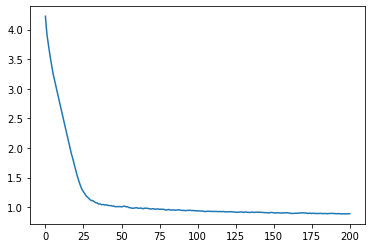

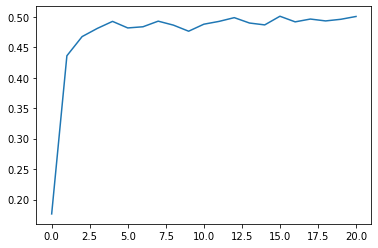

12147.26033115387
40.4908677705129


In [ ]:
start = time.time()
main(model,201,device)
stop = time.time()
print(stop-start)
print((stop-start)/300)

# cifar

Files already downloaded and verified
Files already downloaded and verified
epoch n°0 : loss = 1.9271447658538818, acc = 0.4391
epoch n°1 : loss = 1.7296541929244995
epoch n°2 : loss = 1.6278660297393799
epoch n°3 : loss = 1.5620585680007935
epoch n°4 : loss = 1.5003365278244019
epoch n°5 : loss = 1.452726125717163
epoch n°6 : loss = 1.4269390106201172
epoch n°7 : loss = 1.3970474004745483
epoch n°8 : loss = 1.3732612133026123
epoch n°9 : loss = 1.355334758758545
epoch n°10 : loss = 1.3363455533981323, acc = 0.6774
epoch n°11 : loss = 1.3240610361099243
epoch n°12 : loss = 1.3070828914642334
epoch n°13 : loss = 1.293327808380127
epoch n°14 : loss = 1.2824100255966187
epoch n°15 : loss = 1.264868974685669
epoch n°16 : loss = 1.2516807317733765
epoch n°17 : loss = 1.251755714416504
epoch n°18 : loss = 1.2340495586395264
epoch n°19 : loss = 1.2231149673461914
epoch n°20 : loss = 1.2139772176742554, acc = 0.7183
epoch n°21 : loss = 1.207063913345337
epoch n°22 : loss = 1.1953327655792236
e

epoch n°200 : loss = 0.8004977703094482, acc = 0.8041
epoch n°201 : loss = 0.8041687607765198
epoch n°202 : loss = 0.8046221137046814
epoch n°203 : loss = 0.8002976775169373
epoch n°204 : loss = 0.8021979928016663
epoch n°205 : loss = 0.8015573620796204
epoch n°206 : loss = 0.8026624917984009
epoch n°207 : loss = 0.8011125922203064
epoch n°208 : loss = 0.804206371307373
epoch n°209 : loss = 0.798515796661377
epoch n°210 : loss = 0.7995201349258423, acc = 0.8011
epoch n°211 : loss = 0.796248197555542
epoch n°212 : loss = 0.8019787669181824
epoch n°213 : loss = 0.7943850755691528
epoch n°214 : loss = 0.8017401099205017
epoch n°215 : loss = 0.794393002986908
epoch n°216 : loss = 0.7975180745124817
epoch n°217 : loss = 0.7942244410514832
epoch n°218 : loss = 0.7883605360984802
epoch n°219 : loss = 0.7937614321708679
epoch n°220 : loss = 0.7935479879379272, acc = 0.7959
epoch n°221 : loss = 0.7909875512123108
epoch n°222 : loss = 0.792320728302002
epoch n°223 : loss = 0.7905535697937012
epo

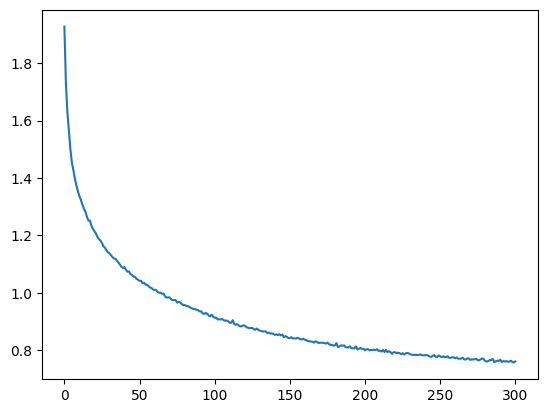

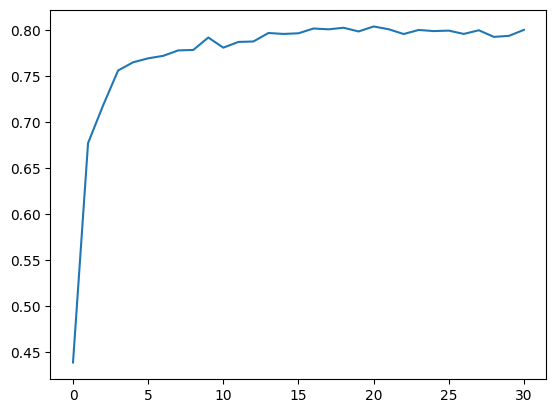

17520.771403074265
58.40257134358088


In [ ]:
start = time.time()
main_10(model2,301,device)
stop = time.time()
print(stop-start)
print((stop-start)/300)

In [ ]:
torch.save(model2.state_dict(), "model_light")

In [ ]:
n_blocks = [3,4,5,2]
embedding_sizes = [32,64,196,320]
head_counts = [4,4,8,8]
head_dims = [24,24,24,24]
mlp_ratios = [8,8,4,4]
folds = [8,4,2,1]
num_classes = 10
device = 'cuda'
model3 = Model(embedding_sizes,num_classes,n_blocks=n_blocks,head_counts=head_counts,head_dims=head_dims,mlp_ratios=mlp_ratios,dropout=0.5,droppath=0.2).to(device)
summary(model3,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             672
          Identity-2           [-1, 32, 16, 16]               0
      PointReducer-3           [-1, 32, 16, 16]               0
         GroupNorm-4           [-1, 32, 16, 16]              64
            Conv2d-5           [-1, 96, 16, 16]           3,168
            Conv2d-6           [-1, 96, 16, 16]           3,168
 AdaptiveAvgPool2d-7             [-1, 24, 2, 2]               0
 AdaptiveAvgPool2d-8             [-1, 24, 2, 2]               0
            Conv2d-9           [-1, 32, 16, 16]           3,104
          Cluster-10           [-1, 32, 16, 16]               0
         DropPath-11           [-1, 32, 16, 16]               0
        GroupNorm-12           [-1, 32, 16, 16]              64
           Conv2d-13          [-1, 256, 16, 16]           8,448
             GELU-14          [-1, 256,

Files already downloaded and verified
Files already downloaded and verified
epoch n°0 : loss = 1.9328240156173706, acc = 0.4204
epoch n°1 : loss = 1.7159420251846313
epoch n°2 : loss = 1.610273838043213
epoch n°3 : loss = 1.539750576019287
epoch n°4 : loss = 1.486894130706787
epoch n°5 : loss = 1.4494279623031616
epoch n°6 : loss = 1.416831612586975
epoch n°7 : loss = 1.3996397256851196
epoch n°8 : loss = 1.3708139657974243
epoch n°9 : loss = 1.35173761844635
epoch n°10 : loss = 1.3355356454849243, acc = 0.6637
epoch n°11 : loss = 1.321897029876709
epoch n°12 : loss = 1.307172417640686
epoch n°13 : loss = 1.292992115020752
epoch n°14 : loss = 1.2811042070388794
epoch n°15 : loss = 1.2661011219024658
epoch n°16 : loss = 1.2542617321014404
epoch n°17 : loss = 1.244762897491455
epoch n°18 : loss = 1.2276016473770142
epoch n°19 : loss = 1.2245979309082031
epoch n°20 : loss = 1.2164804935455322, acc = 0.7271
epoch n°21 : loss = 1.2059478759765625
epoch n°22 : loss = 1.195762276649475
epoch 

epoch n°200 : loss = 0.783096432685852, acc = 0.7922
epoch n°201 : loss = 0.7834306955337524
epoch n°202 : loss = 0.7851455807685852
epoch n°203 : loss = 0.7783170342445374
epoch n°204 : loss = 0.7815415859222412
epoch n°205 : loss = 0.7811168432235718
epoch n°206 : loss = 0.7810342907905579
epoch n°207 : loss = 0.7801173329353333
epoch n°208 : loss = 0.7820843458175659
epoch n°209 : loss = 0.7778209447860718
epoch n°210 : loss = 0.7784444093704224, acc = 0.7986
epoch n°211 : loss = 0.77800452709198
epoch n°212 : loss = 0.7807703614234924
epoch n°213 : loss = 0.7771394848823547
epoch n°214 : loss = 0.7751246094703674
epoch n°215 : loss = 0.7785545587539673
epoch n°216 : loss = 0.77503901720047
epoch n°217 : loss = 0.7710268497467041
epoch n°218 : loss = 0.7753242254257202
epoch n°219 : loss = 0.7727935910224915
epoch n°220 : loss = 0.7767393589019775, acc = 0.7984
epoch n°221 : loss = 0.7671293616294861
epoch n°222 : loss = 0.7706679701805115
epoch n°223 : loss = 0.7734106779098511
epo

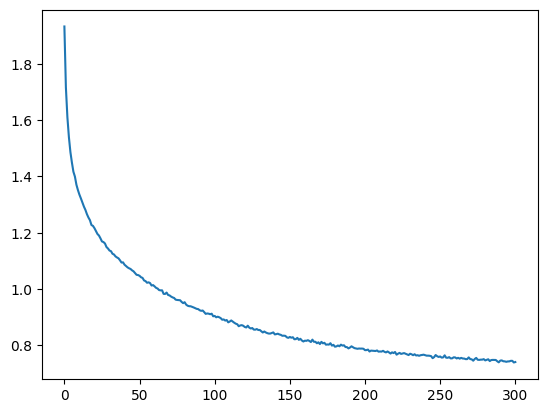

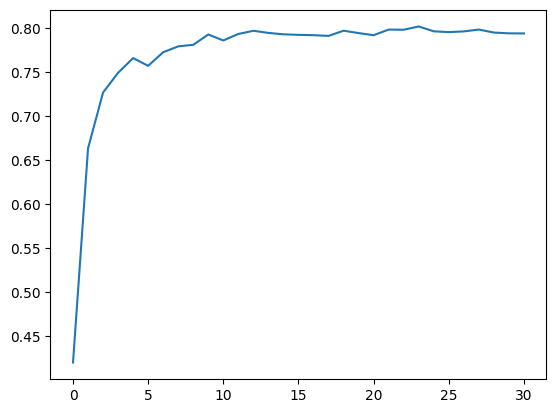

24113.19733119011
80.37732443730036


In [ ]:
start = time.time()
main_10(model3,301,device)
stop = time.time()
print(stop-start)
print((stop-start)/300)

In [ ]:
torch.save(model3.state_dict(), "model_tiny")